## Generate tank bathymetry 

I still need to make into cylindrical coords. Thanks Idalia for your awesome make_mackenzie notebook :-) 

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from netCDF4 import Dataset
import seaborn as sns
import time
%matplotlib inline

In [57]:
sns.set_style('dark')

In [113]:
def tanktopo(y, y_base, y_break, y_coast,
             fluid_depth, z_bottom, z_break, z_wall):
    
    ''' This function generates the topographical profile of the continental
    slope and shelf without the canyon. The profile is created in parts using
    the equation of a line: topography = z2 = (m * y2) - (m* y1) + z1, where
    the values for y represent key distances along the cross-shore direction
    and the values for z2 are the calculated depths based on a known z1 depth.
    '''
    
    sls_ct = (z_wall - z_break) / (y_coast - y_break)
    sls_sb = (z_break - z_bottom) / (y_break - y_base)
    topo_sp = np.zeros(len(y))
    slope_profile = np.zeros(len(y))
   
    for jj in np.arange(len(y)):

        if y[jj] > y_base and y[jj] <= y_break:
            topo_sp[jj] = (sls_sb * y[jj]) - (sls_sb * y_base) + z_bottom
                    
        elif y[jj] > y_break and y[jj] < y_coast:
            topo_sp[jj] = (sls_ct * y[jj]) - (sls_ct * y_break) + z_break
                                  
        elif y[jj] >= y_coast:
            topo_sp[jj] = z_wall

        slope_profile[jj] = topo_sp[jj] - fluid_depth
        
    return slope_profile
#----------------------------------------------------------------------------------

def canyontopo(y, y_base, y_break, y_head, y_coast,
               fluid_depth, z_bottom, z_break, z_wall):
    
    ''' This function generates the topographical profile for the canyon along
    its axis (cross-shore direction). Similar to tanktopo, the profile is
    formed using a collection of lines.
    '''
    
    slc_L = (z_break - z_bottom) / (y_head - y_base)
    slc_ct = (z_wall - z_break) / (y_coast - y_head)
    topo_cp = np.zeros(len(y))
    canyon_profile = np.zeros(len(y))
    
    for ii in np.arange(len(y)):
        
        if y[ii] <= y_base:
            topo_cp[ii] = z_bottom
        
        elif y[ii] > y_base and y[ii] <= y_head:
            topo_cp[ii] = (slc_L * y[ii]) - (slc_L * y_base) + z_bottom
                    
        elif y[ii] > y_head and y[ii] <= y_coast :      
            topo_cp[ii] = (slc_ct * y[ii]) - (slc_ct * y_head) + z_break
          
        elif y[ii] > y_coast:
            topo_cp[ii] = z_wall
        
        canyon_profile[ii] = topo_cp[ii] - fluid_depth
 
    return canyon_profile
#----------------------------------------------------------------------------------
   
def widthprofile(y, y_base, y_break, y_head, y_coast, cR, L,
                 w_break, w_mid, w_head, p):
    
    ''' This function defines the width profile of the canyon (top-down view).
    The width of the canyon is defined for all distances in the cross-shore
    direction. 
    '''

    sigmaa = 1.0 / ((9e-7) * cR)
    half = -w_break / 2.0+ w_mid / 2.0
    e = (L / 2.0 - sigmaa * half**2) / half**p 
    sc = 1
    dG_dxh = p * e * (w_head - w_break / 2)**(p-1) + 2 * sigmaa * (w_head - w_break)
    dh = 0.5 / dG_dxh / sc
    Ah = (w_break - w_head) / (y_base - y_head)**2;
    wp = np.zeros(len(y))

    for l in np.arange(len(y)):

            if y[l] <= y_base:
                wp[l] = w_break

            elif y[l] > y_base and y[l] <= y_head:   
                wp[l] = Ah * (y[l] - y_head)**2 + dh * (y[l] - y_head) + w_head

            elif y[l] > y_head and y[l] <= y_coast:
                wp[l] = wp[l-1]
            
            elif y[l] > y_coast:
                wp[l] = w_break
                
        
    width_profile = wp 
    return width_profile
#----------------------------------------------------------------------------------

def make_topo_smooth(y, y_base, y_break, y_head, y_coast, cR, L,
                     x, x_wall, w_break, w_mid, w_head, p,
                     fluid_depth, z_bottom, z_break, z_wall):
    
    ''' This function returns the depth field of the continental slope and
    shelf with a sech-shaped canyon. It uses the functions tanktopo,
    canyontopo, and widthprofile.
    
    :arg y: Array of cross-shore distances
    :arg y_base: Distance to the base of the continental slope
    :arg y_break: Distance to the shelf break
    :arg y_head: Distance to the canyon head
    :arg y_coast: Distance beyond y_head where shelf flattens
    :arg cR: Radius of curvature at the shelf break depth
    :arg x: Array of alongshore distances
    :arg x_wall: Width of the Domain
    :arg w_break: Width of the canyon at the shelf break
    :arg w_mid: Width of the canyon half-way along its length
    :arg w_head: Width of the canyon head
    :arg p: Geometric parameter used to help shape of canyon
    :arg fluid_depth: Total height of the fluid in the domain.
    :arg z_bottom: Depth of the deep ocean (measured upward)
    :arg z_break: Depth of the shelf break (measured upward)
    :arg z_wall: Depth of shelf beyond y_coast (measured upward)
    '''
    
    # Topography without the canyon
    slope_profile = tanktopo(y, y_base, y_break, y_coast,
                             fluid_depth, z_bottom, z_break, z_wall)
    
    # Slope of the canyon
    canyon_profile = canyontopo(y, y_base, y_break, y_head, y_coast,
                                fluid_depth, z_bottom, z_break, z_wall)
  
    # Slope of the canyon as well as the shape
    width_profile = widthprofile(y, y_base, y_break, y_head, y_coast, cR, L,
                                 w_break, w_mid, w_head, p)
  
    # Depth of the canyon (negative values set to zero)
    canyondepth = slope_profile - canyon_profile
  
    canyondepth[canyondepth < 0] = 0
  
    # Sech shaped canyon
    topography = np.zeros((len(y),len(x)))
    for j in np.arange(len(x)):
        topography[:,j] = (slope_profile - canyondepth * 
                           (1.0 / (np.cosh(0.5 / width_profile * (x[j] - (0.5 * x_wall))))**50))
    #topography=np.transpose(topography)
    topo = -1* topography[0:-1, :]
   
    return topo
#----------------------------------------------------------------------------------

def set_domain_grid(xsize, ysize, x_wall, y_wall):
    
    ''' Sets up the domain dimensions and grid cells used
    to generate the canyon bathymetry.
    
    :arg xsize: X direction dimension (alongshore)
    :arg ysize: Y direction dimension (cross-shore)
    '''
    
    xgrd_all = np.arange(0, xsize, 1)
    xgrd_bounds = [0, xsize-1]
    xval_bounds = [0, x_wall]
    xval_all = np.interp(xgrd_all, xgrd_bounds, xval_bounds)
    x_edge = np.zeros(xsize)
    x_edge[:] = xval_all[:]
    x = ((x_edge[1:] + x_edge[0:-1])/2)

    ygrd_all = np.arange(0, ysize, 1)
    ygrd_bounds = [0, ysize-1]
    yval_bounds = [0, y_wall]
    yval_all = np.interp(ygrd_all, ygrd_bounds, yval_bounds)
    y_edge = np.zeros(ysize)
    y_edge[:] = yval_all[:]
    y = ((y_edge[1:] + y_edge[0:-1])/2)

    X, Y = np.meshgrid(x, y)
    
    return x, y, y_edge, X, Y
#----------------------------------------------------------------------------------

def create_bathy_file(X, Y, bathymetry, filename, title, description):
    
    """ This function creates a netCDF4 file for
    the canyon bathymetry given the filename and 
    the x and y grid cell number.
    
    :arg X: Alongshore indices (from set_domain_grid)
    :arg Y: Cross-shore indices (from set_domain_grid)
    :arg bathymetry: Canyon bathymetry (from make_topo_smooth)
    :arg filename: Directory and name of netcdf file
    :arg title: Title of bathymetry version
    :arg description: Details about bathymetry version
    """
    
    dataset = Dataset(filename, 'w')
    file_x = dataset.createDimension('x', X.shape[1])
    file_y = dataset.createDimension('y', X.shape[0])

    file_X = dataset.createVariable('X', 'f8', ('y','x'))
    file_Y = dataset.createVariable('Y', 'f8', ('y','x'))
    Bathymetry = dataset.createVariable('Bathymetry', 'f8', ('y','x'))

    dataset.title = title
    dataset.author = 'Karina Ramos Musalem'
    dataset.institution = 'Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia'
    dataset.source = 'bitbucket.org/CanyonsUBC/BuildCanyon/Bathymetry/GenerateTankBathymetry.ipynb'
    dataset.description = description
    dataset.timeStamp = time.ctime(time.time())
    file_X.standard_name = 'Alongshelf Distance'
    file_X.units = 'm'
    file_Y.standard_name = 'Cross-shelf Distance'
    file_Y.units = 'm'
    Bathymetry.standard_name = 'Bathymetry'
    Bathymetry.units = 'm'
    Bathymetry.positive = 'upward'

    file_X[:] = X[:]
    file_Y[:] = Y[:]
    Bathymetry[:] = bathymetry[:]

    dataset.close()
    
#----------------------------------------------------------------------------------

def define_dimensions():
    ''' This function defines all dimensions that are used to create 
    the bathymetry profile.
    '''
    
    # Alongshore
    w_break = 0.08 # m 
    w_mid = 0.05  
    w_head = 0.02 
    width_f = 0.08
    x_wall = width_f * 7

    # Adjustments
    mouth = 0.225
    length = 0.12
    y_wall_1300 = (mouth + length) * 2.0 
    y_wall = (mouth + length) * 2.0
    adjust = y_wall - y_wall_1300

    # Cross-shore
    cR = 0.02
    L = 0.12     
    y_base =  0.24 #np.mean([16500.0,7000.0]) + adjust 
    y_break = 0.275 #np.mean([38000.0, 57500.0]) + adjust 
    y_coast = 0.5 #148105.0 + adjust 
    y_head = y_break + L

    # Depths
    fluid_depth = 0.12 #1300.0
    z_bottom = fluid_depth - fluid_depth
    z_break = fluid_depth - 0.022
    z_wall = fluid_depth - 0.01
    p = 4.0
    
    return w_break, w_mid, w_head, width_f, x_wall,\
            mouth, length, y_wall_1300, y_wall, adjust,\
            cR, L, y_base, y_break, y_coast, y_head,\
            fluid_depth, z_bottom, z_break, z_wall, p

In [114]:
w_break, w_mid, w_head, width_f, x_wall,mouth, length, y_wall_1300, y_wall, adjust,\
cR, L, y_base, y_break, y_coast, y_head,fluid_depth, z_bottom, z_break, z_wall, p = define_dimensions()


In [115]:
xsize = 360
ysize = 360
x, y, y_edge, X, Y = set_domain_grid(xsize, ysize, x_wall, y_wall)

In [116]:
bathymetry = make_topo_smooth(y_edge, y_base, y_break, y_head, y_coast, cR, L,
                              x, x_wall, w_break, w_mid, w_head, p,
                              fluid_depth, z_bottom, z_break, z_wall)
bathymetry.shape

(359, 359)

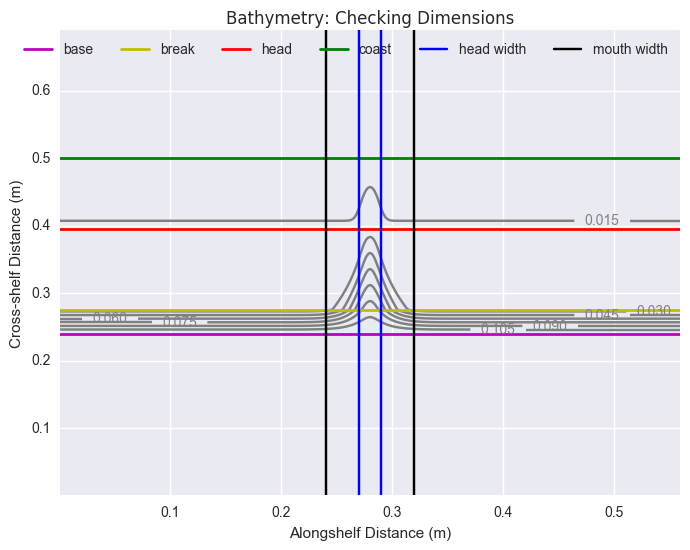

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.set_title('Bathymetry: Checking Dimensions')
ax.set_xlabel('Alongshelf Distance (m)'); ax.set_ylabel('Cross-shelf Distance (m)')
cs = ax.contour(X, Y, bathymetry, 10, colors='grey', linestyles='solid')
CS = ax.contour(X, Y, bathymetry, levels = [-.12, -0.022, 0], colors='grey',linestyles='--')
ax.clabel(cs, inline=1); ax.clabel(CS, inline=1)

# markers
ys = [y_base, y_break, y_head, y_coast]
labs = ['base', 'break', 'head', 'coast']
cs = ['m', 'y', 'r', 'g']
for i, j, k in zip(ys, labs, cs):
    ax.axhline(i, c=k, label=j, linewidth=2)
ax.axvline((x_wall/2)-(w_head/2)); plt.axvline((x_wall/2)+(w_head/2), label='head width')
ax.axvline((x_wall/2)+(w_break/2), c='k'); plt.axvline((x_wall/2)-(w_break/2), c='k', label='mouth width')
ax.legend(ncol=7)
#ax.set_ylim(0,0.5)

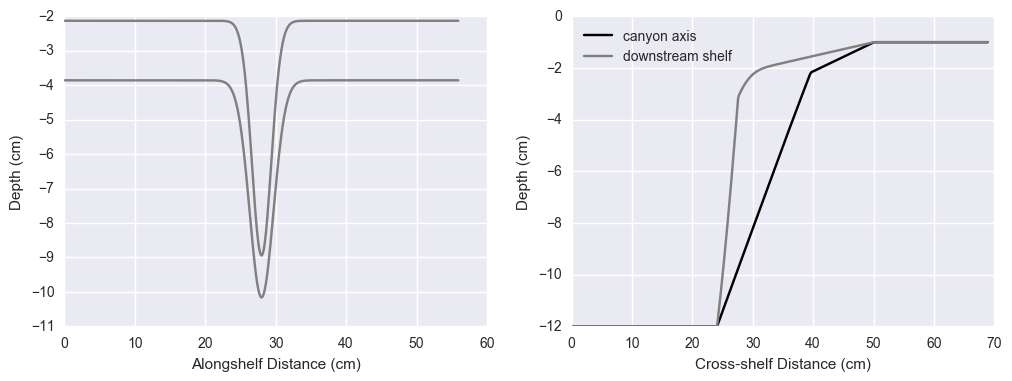

In [118]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.set_xlabel('Alongshelf Distance (cm)'); ax1.set_ylabel('Depth (cm)')
cs = ax1.plot(X[140,:]*100, -bathymetry[140,:]*100, color='grey', linestyle='solid')
#cs = ax1.plot(X[80,:]*100, -bathymetry[80,:]*100, color='grey', linestyle='solid')
cs = ax1.plot(X[150,:]*100, -bathymetry[150,:]*100, color='grey', linestyle='solid')

ax2.set_xlabel('Cross-shelf Distance (cm)'); ax2.set_ylabel('Depth (cm)')
ax2.plot(Y[:,180]*100, -bathymetry[:,180]*100, color='black', label='canyon axis')
ax2.plot(Y[:,200]*100, -bathymetry[:,200]*100, color='grey', label='downstream shelf')
ax2.legend(loc=0)
